In [89]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

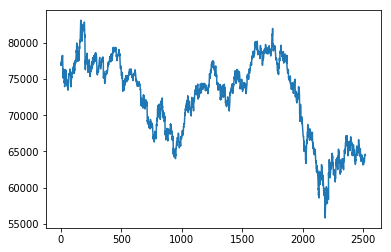

In [90]:
#initials for testing the code
#------------------------------------------------------------------------
#variables
lookback = 252*10
#-------------------------------------------------------------------------
#reading file 
file = pd.read_csv(r'/home/anshul/Desktop/Quantiacs/tickerData/F_AD.txt')
#getting features
CLOSE = np.array(file.loc[:lookback-1, [' CLOSE']])
#plt.plot(CLOSE)
VOL = np.array(file.loc[:lookback-1, [' VOL']])
#plt.plot(VOL)
OI = np.array(file.loc[:lookback-1, [' VOL']])
#plt.plot(OI)
HIGH = np.array(file.loc[:lookback-1, [' HIGH']])
#plt.plot(HIGH)
LOW = np.array(file.loc[:lookback-1, [' LOW']])
#plt.plot(LOW)
OPEN = np.array(file.loc[:lookback-1, [' OPEN']])
plt.plot(OPEN)

In [91]:
#code
#------------------------------------------------------------------------------
#variables
dimension = 5
#------------------------------------------------------------------------------
poly = PolynomialFeatures(degree=dimension)
reg = linear_model.LinearRegression()
#------------------------------------------------------------------------------
#predicting volume
reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), VOL[:])
vol_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
#plt.plot(VOL[:])
#predicting open price
reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1,1)), OPEN[:])
open_predict = reg.predict(poly.fit_transform(np.array([[lookback]])))
#predicting close price
X = np.append(poly.fit_transform(VOL[:]), poly.fit_transform(OPEN[:]), axis=1)
reg.fit(X,CLOSE[:])
x = np.append(poly.fit_transform(vol_predict),poly.fit_transform(open_predict),axis=1)
close_predict = reg.predict(x)
#trend = (close_predict - CLOSE[-1]) / CLOSE[-1]
print('predicted', close_predict[0])
#print(F_)
print('actual', file.loc[252, [' CLOSE']])
print('last close', CLOSE[-1:])

predicted [69304.62343592]
actual  CLOSE    76560.0
Name: 252, dtype: float64
last close [[64700.]]


In [92]:
#code II
##Idea: using past 5 days data, 20 day sma, 60 day sma and volatility(standard deviation) [last two items from bollinger bands]

def bollingerbands(a, n=20, m=60):
    sma20 = np.nansum(a[-20:])/20
    sma60 = np.nansum(a[-60:])/60 
    std5 = np.std(a[-5:],ddof=1)
    std20 = np.std(a[-20:],ddof=1)
    std60 = np.std(a[-60:],ddof=1)
    return sma20, sma60, std5, std20, std60

#=60
y = CLOSE[60:]
#print(y)
X_close = np.concatenate([CLOSE[i-5:i] for i in range(60, lookback)], axis=1).T
print(X_close.shape)
[n,m] = X_close.shape
X_others = np.zeros((n,5), dtype=np.float)
print(X_others.shape)
for j in range(192):
    sma20, sma40, std5, std20, std60 = bollingerbands(CLOSE[j:j+60]) 
    #print(sma20, sma40, std)
    X_others[j,:] = [sma20, sma40, std5, std20, std60]
print(X_others.shape)
print(X_close.shape)

X = np.append(X_close, X_others, axis=1)
print(X.shape)
reg = linear_model.LinearRegression()
reg.fit(X_close,y)
R_sq_close = reg.score(X_close,y)
#plt.plot(y)
#plt.plot(reg.predict(X_close))
y_close = reg.predict(X_close)

(2460, 5)
(2460, 5)
(2460, 5)
(2460, 5)
(2460, 10)


0.9947295383154442 0.9947003329247638


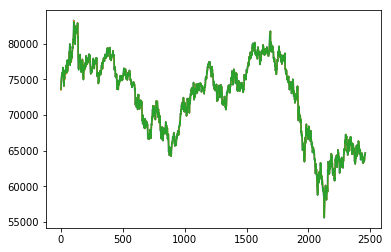

In [93]:
#plt.plot(y)
reg.fit(X,y)
R_sq_all = reg.score(X,y)
y_all = reg.predict(X)
#plt.plot(reg.predict(X))
plt.plot(y)
plt.plot(y_close)
plt.plot(y_all)
print(R_sq_all, R_sq_close)

In [95]:
x_close = np.zeros((5,1)).T
x_close = CLOSE[-5:].T
print(x_close)

[[64340. 64550. 64560. 64630. 64700.]]


In [155]:
#TS code II
class mystrategy(object):
    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):
        #function def -> last ke 20, 60 din lega
        def bollingerbands(a, n=20, m=60):
            sma20 = np.nansum(a[-20:])/20
            sma60 = np.nansum(a[-60:])/60 
            std5 = np.std(a[-5:],ddof=1)
            std20 = np.std(a[-20:],ddof=1)
            std60 = np.std(a[-60:],ddof=1)
            return sma20, sma60, std5, std20, std60
        
        def predict(close, lookback):
            ##training
                 #X = np.concatenate([CLOSE[i:i + gap] for i in range(lookback - gap)], axis=1).T 
            X_close = np.concatenate([close[i+55:i+60] for i in range(0, lookback-60)], axis=1).T
            #print('Shape:', X_close.shape)
            [n,m] = X_close.shape
            X_others = np.zeros((n,5), dtype=np.float)
            #print(X_others.shape)
            for j in range(lookback-60):
                sma20, sma40, std5, std20, std60 = bollingerbands(close[j:j+60]) 
                #print(sma20, sma40, std)
                X_others[j,:] = [sma20, sma40, std5, std20, std60]
            #print(X_others.shape)
            #print(X_close.shape)
            X = np.append(X_close, X_others, axis=1)
            y = close[60:]                                 #y = CLOSE[60:]
            #print(X.shape, y.shape)
            reg = linear_model.LinearRegression()
            try:
                reg.fit(X,y)
                ###predicting
                x_others = np.zeros((5,1)).T
                x_close = np.zeros((5,1)).T
                sma20, sma40, std5, std20, std60 = bollingerbands(close[:])
                x_others[:] = np.array([sma20, sma40, std5, std20, std60])
                x_close = close[-5:].T
                #print(x_close.shape, x_others.shape)
                x = np.append(x_close, x_others, axis=1)
                #print(x.shape)
                pred_pr = reg.predict(x)
                last_pr = close[-1]
                if pred_pr >= last_pr*(1.02):
                    position = 1.00
                elif pred_pr <= last_pr*(0.98):
                    position = -1.00
                else:
                    position = 0.00
            except ValueError:
                position = 0.00
                
            return position
        
        # Get parameters from setting
        nMarkets = len(settings['markets'])
        lookback = settings['lookback']
        dimension = settings['dimension']
        threshold = settings['threshold']
        
        pos = np.zeros((1,nMarkets), dtype=np.float)
        
        poly = PolynomialFeatures(degree=dimension)
        reg = linear_model.LinearRegression()
        #x_others = np.zeros((5,1)).T
        #x_close = np.zeros((5,1)).T
        
        for market in range(nMarkets):
            pos[0, market] = predict(CLOSE[:, market].reshape(-1,1), lookback)
    
        return pos, settings
                
                         
    def mySettings(self):
        #""" Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD','F_CL','F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        #settings['beginInSample'] = '19900101'
        #settings['endInSample'] = '20170522'
        settings['lookback'] = 252
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05
        settings['dimension'] = 5
        settings['threshold'] = 0.3

        return settings   

Loading Data...
Done!
Evaluating Trading System <class '__main__.mystrategy'>


/home/anshul/anaconda3/lib/python3.6/site-packages/quantiacsToolbox/quantiacsToolbox.py:881: RuntimeWarning: invalid value encountered in true_divide
  position = position / np.sum(abs(position))


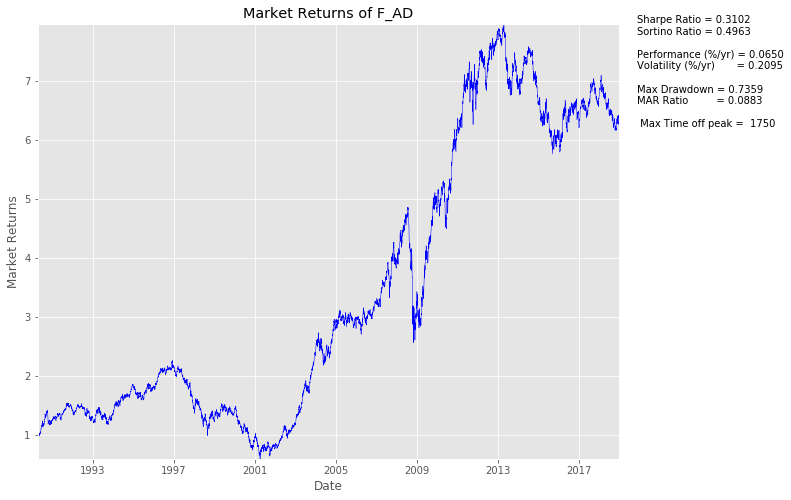

In [156]:
result = quantiacsToolbox.runts(mystrategy)

In [99]:
x_others = np.zeros((5,1)).T
print(x_others.shape)

(1, 5)
